In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import string, re
import pandas_profiling
import itertools 
import pickle
import sklearn
%store -r test_features
%store -r test_labels
%store -r train_features

In [27]:
%load_ext autoreload

In [28]:
%autoreload 2

In [7]:
test_features = pickle.load(open('test_features.pkl', 'rb'))['test_features']
test_labels = pickle.load(open('test_labels.pkl', 'rb'))['test_labels']
train_features = pickle.load(open('train_features.pkl', 'rb'))['train_features']
train_labels = pickle.load(open('train_labels.pkl', 'rb'))['train_labels']

In [8]:
model = requests.get("https://fakenewsstorage.blob.core.windows.net/fakenewsmodels/voting_classifier.pkl")

In [4]:
model = requests.get("https://fakenewsstorage.blob.core.windows.net/fakenewsmodels/random_forest_classifier.pkl")

In [10]:
model = pickle.load(open('models/RandomForestClassifier.pkl', 'rb'))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [19]:
model = pickle.load(open('models/eclf.pkl', 'rb'))

In [26]:
predictions = model.predict(test_features)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
cm = confusion_matrix(test_labels, predictions)
f1_score(test_labels, predictions, average='macro')  

0.998486922121146

In [25]:
cm

array([[1873,    0,    0],
       [   0, 1598,    0],
       [   0,    3,  415]], dtype=int64)

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.tight_layout()

Confusion matrix, without normalization
[[1873    0    0]
 [   0 1598    0]
 [   0    7  411]]


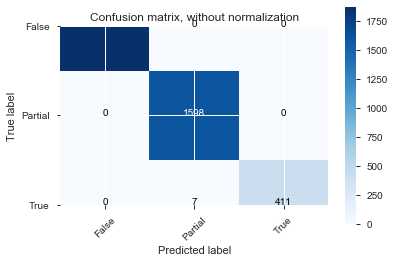

In [14]:
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['False', 'Partial', 'True'],
                      title='Confusion matrix, without normalization')

In [22]:
from sklearn.metrics import accuracy_score
predictions = model.predict(test_features)
print("Training accuracy is: ", accuracy_score(train_labels, model.predict(train_features)))
print("Test accuracy is: ", accuracy_score(test_labels, predictions))

Training accuracy is:  1.0
Test accuracy is:  0.999228593468758


In [37]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

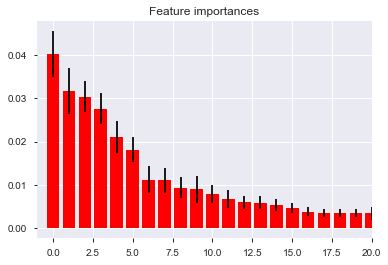

In [36]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, 20]) 
# X.shape[1]]
plt.show()

In [33]:
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 3081 (0.040352)
2. feature 6047 (0.031739)
3. feature 6051 (0.030398)
4. feature 6050 (0.027617)
5. feature 6049 (0.021072)
6. feature 6048 (0.018126)
7. feature 787 (0.011144)
8. feature 310 (0.010993)
9. feature 3106 (0.009315)
10. feature 3105 (0.008970)
11. feature 3107 (0.007912)
12. feature 3108 (0.006705)
13. feature 2970 (0.005925)
14. feature 3109 (0.005867)
15. feature 2941 (0.005374)
16. feature 3110 (0.004617)
17. feature 238 (0.003700)
18. feature 3091 (0.003512)
19. feature 1121 (0.003439)
20. feature 3111 (0.003389)
21. feature 3148 (0.003335)
22. feature 3112 (0.003251)
23. feature 3572 (0.003108)
24. feature 440 (0.003047)
25. feature 921 (0.002824)
26. feature 3113 (0.002701)
27. feature 922 (0.002554)
28. feature 266 (0.002225)
29. feature 3114 (0.002060)
30. feature 1720 (0.002055)
31. feature 2344 (0.001801)
32. feature 2726 (0.001799)
33. feature 2532 (0.001782)
34. feature 2972 (0.001750)
35. feature 3115 (0.001725)
36. feature 1410 (0

In [30]:
from local_modules.scoring.score import calculate_score 

In [31]:
calculate_score(7, 74, 971, 771, 1286, 817, 411, 627, 587)

Precision is: 0.009818938537999753
Recall is: 0.002328874843510748


2.0

In [32]:
calculate_score(7, 74, 971, 771, 1286, 817, 411, 627, 587)

Precision is: 0.009818938537999753
Recall is: 0.002328874843510748
Updated


2.0